# 1. Import libraries

In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import eda_helper_functions

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.ensemble import IsolationForest

# 2. Read the Training Data

In [2]:
file_path = r"D:\flight-price-pred-sagemaker\data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-06,Delhi,Cochin,20:25:00,01:30:00,305,1,No Info,5054
1,Indigo,2019-06-03,Kolkata,Banglore,09:35:00,12:10:00,155,0,No Info,4804
2,Air Asia,2019-03-24,Banglore,New Delhi,23:25:00,02:10:00,165,0,No Info,4482
3,Goair,2019-05-18,Kolkata,Banglore,23:30:00,07:45:00,495,1,No Info,7335
4,Indigo,2019-05-18,Delhi,Cochin,16:00:00,21:00:00,300,1,No Info,6069
...,...,...,...,...,...,...,...,...,...,...
6395,Jet Airways,2019-04-01,Kolkata,Banglore,20:00:00,16:20:00,1220,1,In-flight meal not included,7064
6396,Indigo,2019-05-18,Delhi,Cochin,06:50:00,22:30:00,940,1,No Info,7144
6397,Indigo,2019-03-18,Kolkata,Banglore,15:20:00,17:55:00,155,0,No Info,4462
6398,Jet Airways,2019-06-18,Mumbai,Hyderabad,10:20:00,11:50:00,90,0,No Info,8040


In [3]:
train.dtypes

airline            object
date_of_journey    object
source             object
destination        object
dep_time           object
arrival_time       object
duration            int64
total_stops         int64
additional_info    object
price               int64
dtype: object

In [4]:
train = train.assign(**{
    col : pd.to_datetime(train.loc[:, col], dayfirst = False)
    for col in ["date_of_journey", "dep_time", "arrival_time"]
}  
)

In [5]:
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops                 int64
additional_info            object
price                       int64
dtype: object

In [6]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-06,Delhi,Cochin,2024-04-29 20:25:00,2024-04-29 01:30:00,305,1,No Info,5054
1,Indigo,2019-06-03,Kolkata,Banglore,2024-04-29 09:35:00,2024-04-29 12:10:00,155,0,No Info,4804
2,Air Asia,2019-03-24,Banglore,New Delhi,2024-04-29 23:25:00,2024-04-29 02:10:00,165,0,No Info,4482
3,Goair,2019-05-18,Kolkata,Banglore,2024-04-29 23:30:00,2024-04-29 07:45:00,495,1,No Info,7335
4,Indigo,2019-05-18,Delhi,Cochin,2024-04-29 16:00:00,2024-04-29 21:00:00,300,1,No Info,6069


# 3. High Level Summary

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6400 non-null   object        
 1   date_of_journey  6400 non-null   datetime64[ns]
 2   source           6400 non-null   object        
 3   destination      6400 non-null   object        
 4   dep_time         6400 non-null   datetime64[ns]
 5   arrival_time     6400 non-null   datetime64[ns]
 6   duration         6400 non-null   int64         
 7   total_stops      6400 non-null   int64         
 8   additional_info  6400 non-null   object        
 9   price            6400 non-null   int64         
dtypes: datetime64[ns](3), int64(3), object(4)
memory usage: 500.1+ KB


In [8]:
train.describe(include = "number")

,duration,total_stops,price
count,6400.000000,6400.000000,6400.000000
mean,633.546094,0.806719,9069.738594
std,501.936078,0.657213,4581.603003
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5277.000000
50%,507.500000,1.000000,8366.000000
75%,915.000000,1.000000,12373.000000
max,2860.000000,3.000000,79512.000000


In [9]:
train.describe(include = "O")

,airline,source,destination,additional_info
count,6400,6400,6400,6400
unique,9,5,6,7
top,Jet Airways,Delhi,Cochin,No Info
freq,2279,2676,2676,5002


In [10]:
(
    train
    .assign(total_stops = train["total_stops"].astype(object))
    .describe(include = "O")
)

,airline,source,destination,total_stops,additional_info
count,6400,6400,6400,6400,6400
unique,9,5,6,4,7
top,Jet Airways,Delhi,Cochin,1,No Info
freq,2279,2676,2676,3472,5002


# 4. High-level Analysis of Missing Values

In [11]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


- No missing values present in the data set

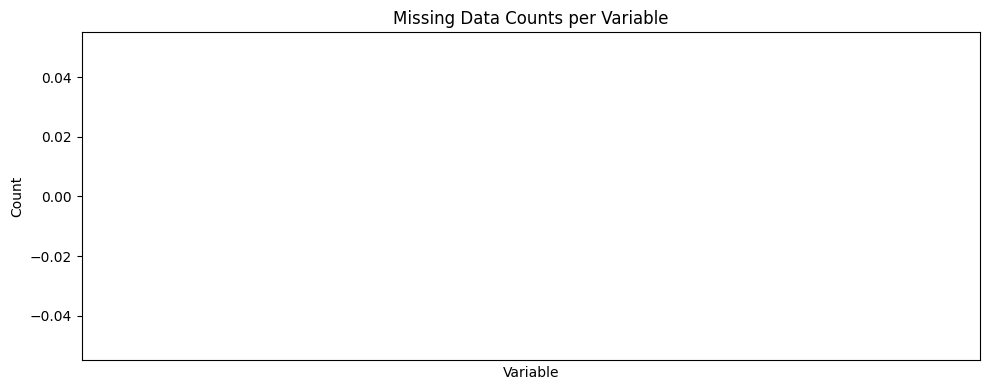

In [12]:
eda_helper_functions.plot_missing_info(train)

In [13]:
# We can use this also for validating missing number in dataset

# import missingno as msno
# %matplotlib inline
# msno.matrix(collisions.sample(250))

# 5. High Level Analysis of Outliers

In [14]:
forest = IsolationForest(n_estimators = 10, random_state = 42)

In [15]:
(
    train
    .assign(outlier = forest.fit_predict(train
                                              .drop(columns = "price")
                                              .select_dtypes(include = "number")))
    .query("outlier == -1")
    # .duration
    # .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
4,Indigo,2019-05-18,Delhi,Cochin,2024-04-29 16:00:00,2024-04-29 21:00:00,300,1,No Info,6069,-1
5,Air India,2019-03-18,Banglore,New Delhi,2024-04-29 08:50:00,2024-04-29 16:30:00,1900,2,No Info,10835,-1
6,Jet Airways,2019-03-09,Delhi,Cochin,2024-04-29 11:00:00,2024-04-29 14:15:00,195,0,In-flight meal not included,7202,-1
9,Jet Airways,2019-05-09,Kolkata,Banglore,2024-04-29 20:25:00,2024-04-29 14:25:00,1080,1,No Info,11467,-1
13,Spicejet,2019-04-24,Kolkata,Banglore,2024-04-29 17:10:00,2024-04-29 19:40:00,150,0,No Info,4174,-1
...,...,...,...,...,...,...,...,...,...,...,...
6389,Indigo,2019-03-21,Mumbai,Hyderabad,2024-04-29 19:05:00,2024-04-29 20:30:00,85,0,No Info,2754,-1
6391,Jet Airways,2019-03-21,Delhi,Cochin,2024-04-29 10:20:00,2024-04-29 18:50:00,1950,2,No Info,11664,-1
6392,Jet Airways,2019-06-12,Banglore,Delhi,2024-04-29 17:45:00,2024-04-29 20:45:00,180,0,In-flight meal not included,5769,-1
6396,Indigo,2019-05-18,Delhi,Cochin,2024-04-29 06:50:00,2024-04-29 22:30:00,940,1,No Info,7144,-1


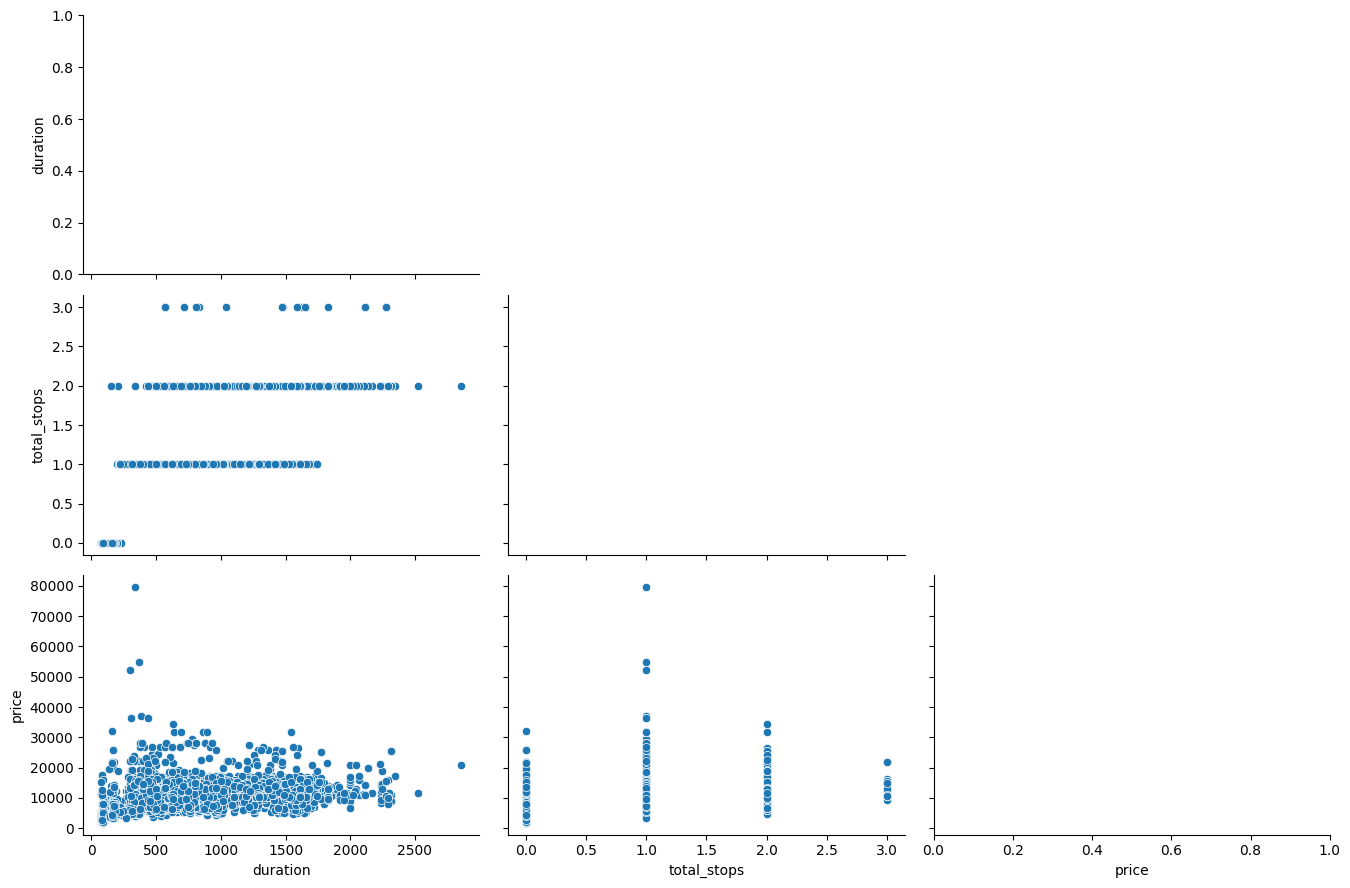

In [16]:
eda_helper_functions.pair_plots(train)

# 7. Correlation Analysis

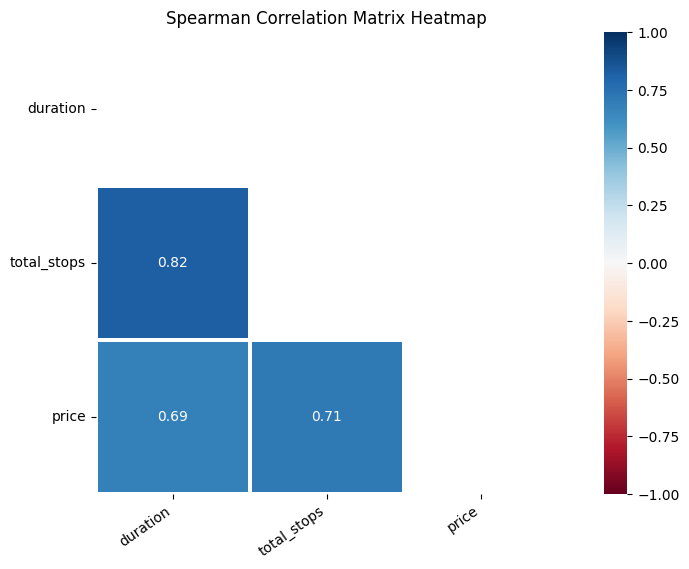

In [17]:
eda_helper_functions.correlation_heatmap(train) # Numerical vrs numerical

- So we can't used linear based model so we will choose Tree based model for this.

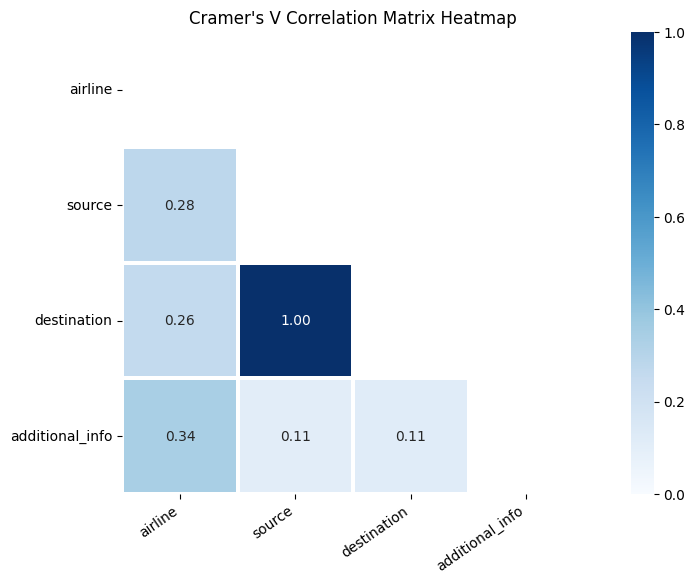

In [18]:
eda_helper_functions.cramersV_heatmap(train) # Categorical Analysis

# 8. Detailed Columns

In [19]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

## 8.1 Airline

In [20]:
eda_helper_functions.cat_summary(train, "airline")

0            Indigo
1            Indigo
2          Air Asia
3             Goair
4            Indigo
           ...     
6395    Jet Airways
6396         Indigo
6397         Indigo
6398    Jet Airways
6399    Jet Airways
Name: airline, Length: 6400, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,400 / 6,400 rows


,
count,6400
unique,9
top,Jet Airways
freq,2279


,count,percentage
category,,
Jet Airways,2279,0.356094
Indigo,1245,0.194531
Air India,1003,0.156719
Multiple Carriers,758,0.118438
Spicejet,492,0.076875
Vistara,301,0.047031
Air Asia,197,0.030781
Goair,124,0.019375
Trujet,1,0.000156


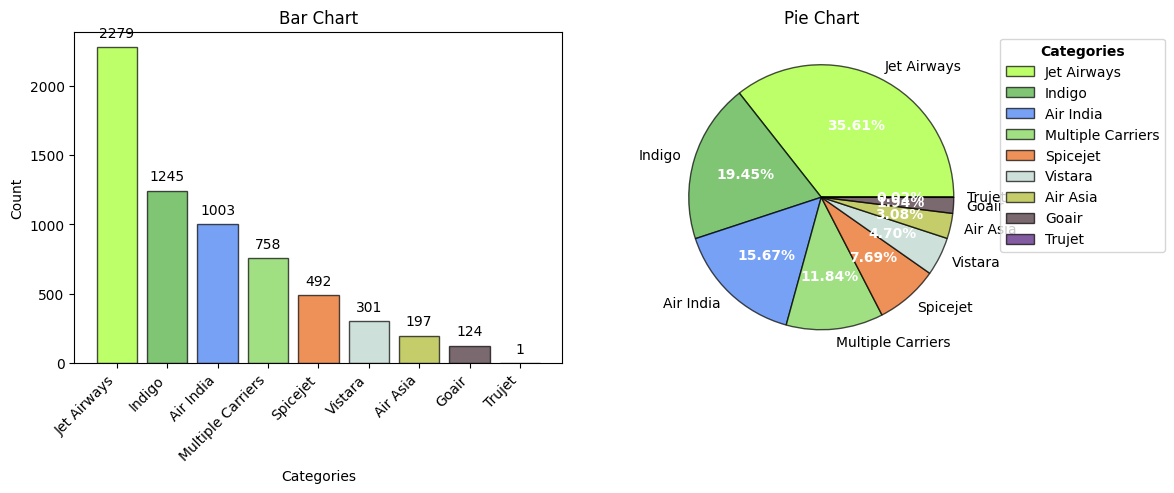

In [21]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud = False)

## 8.2 Source

In [22]:
eda_helper_functions.cat_summary(train, "source")

0          Delhi
1        Kolkata
2       Banglore
3        Kolkata
4          Delhi
          ...   
6395     Kolkata
6396       Delhi
6397     Kolkata
6398      Mumbai
6399     Kolkata
Name: source, Length: 6400, dtype: object

Data Type      : object
Cardinality    : 5 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,400 / 6,400 rows


,
count,6400
unique,5
top,Delhi
freq,2676


,count,percentage
category,,
Delhi,2676,0.418125
Kolkata,1750,0.273438
Banglore,1322,0.206563
Mumbai,426,0.066562
Chennai,226,0.035312


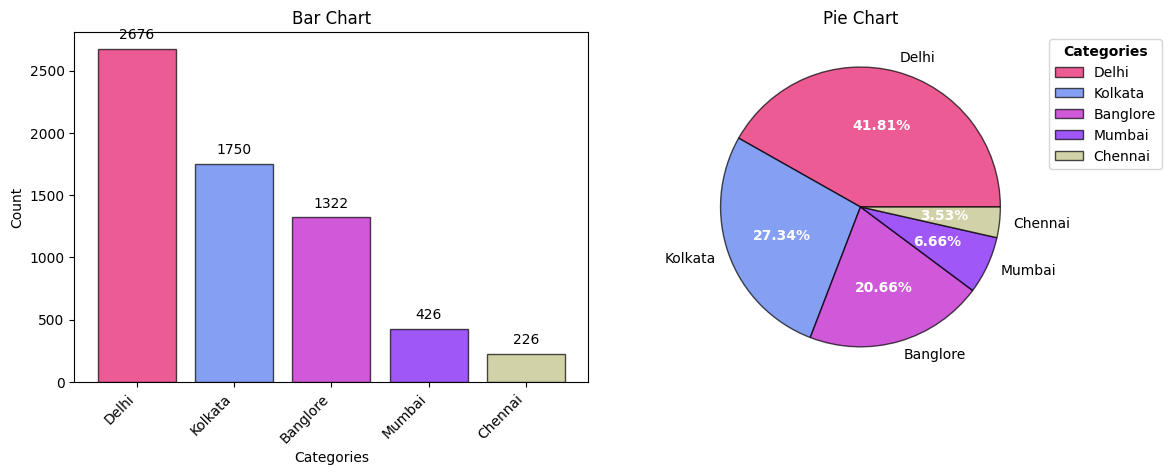

In [23]:
eda_helper_functions.cat_univar_plots(train, "source", show_wordcloud = False)

## 8.3 Destination

In [24]:
eda_helper_functions.cat_summary(train, "destination")

0          Cochin
1        Banglore
2       New Delhi
3        Banglore
4          Cochin
          ...    
6395     Banglore
6396       Cochin
6397     Banglore
6398    Hyderabad
6399     Banglore
Name: destination, Length: 6400, dtype: object

Data Type      : object
Cardinality    : 6 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,400 / 6,400 rows


,
count,6400
unique,6
top,Cochin
freq,2676


,count,percentage
category,,
Cochin,2676,0.418125
Banglore,1750,0.273438
Delhi,768,0.120000
New Delhi,554,0.086563
Hyderabad,426,0.066562
Kolkata,226,0.035312


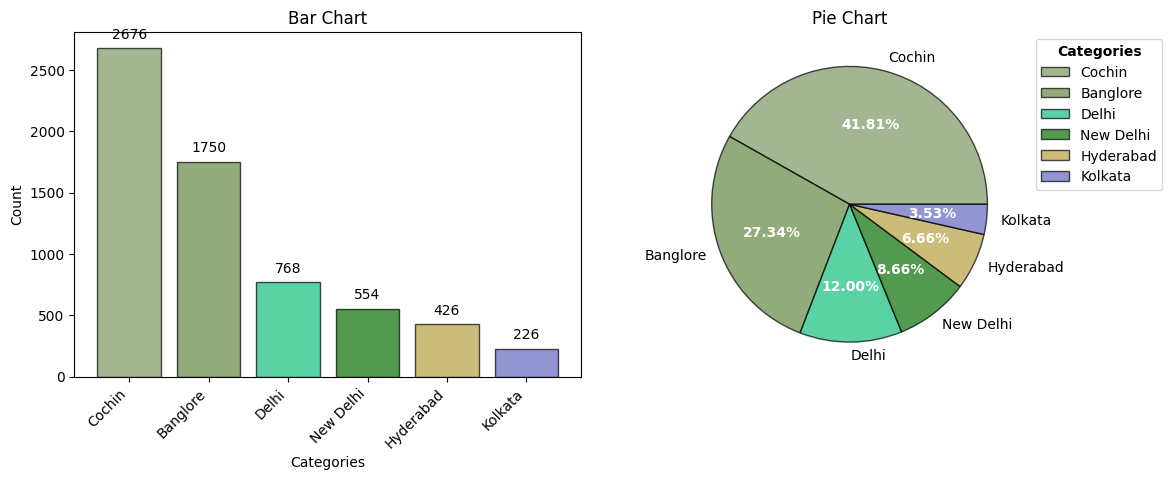

In [25]:
eda_helper_functions.cat_univar_plots(train, "destination", show_wordcloud = False)

## 8.4 Additional Info

In [26]:
eda_helper_functions.cat_summary(train, "additional_info")

0                           No Info
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
6395    In-flight meal not included
6396                        No Info
6397                        No Info
6398                        No Info
6399    In-flight meal not included
Name: additional_info, Length: 6400, dtype: object

Data Type      : object
Cardinality    : 7 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,400 / 6,400 rows


,
count,6400
unique,7
top,No Info
freq,5002


,count,percentage
category,,
No Info,5002,0.781563
In-flight meal not included,1196,0.186875
No check-in baggage included,186,0.029063
1 Long layover,10,0.001563
Change airports,3,0.000469
Business class,2,0.000313
2 Long layover,1,0.000156


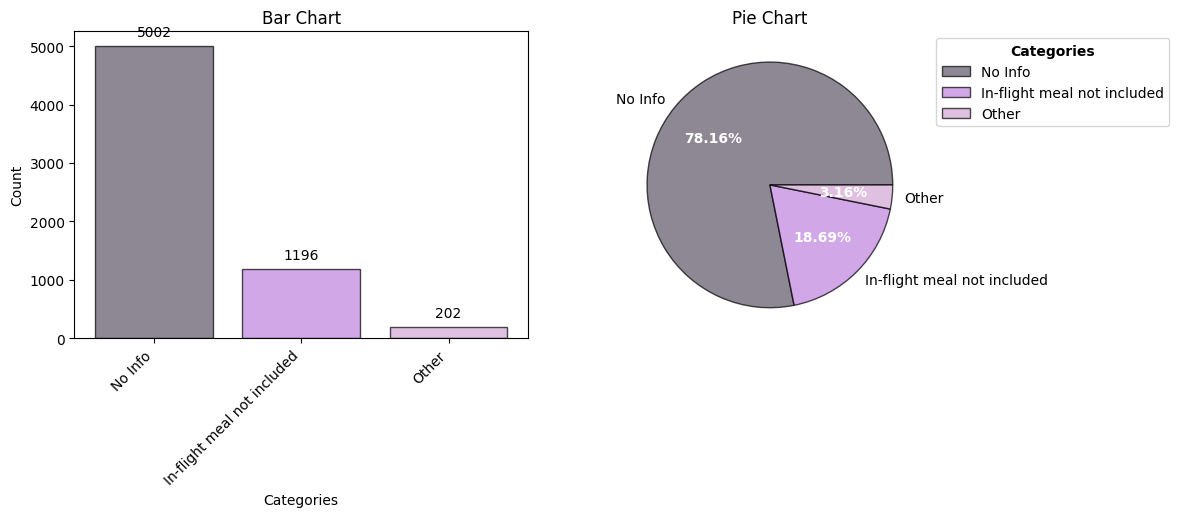

In [27]:
eda_helper_functions.cat_univar_plots(train, "additional_info", show_wordcloud = False, k=2)

## 8.6 Bivariate anaysis for Price vrs Airline

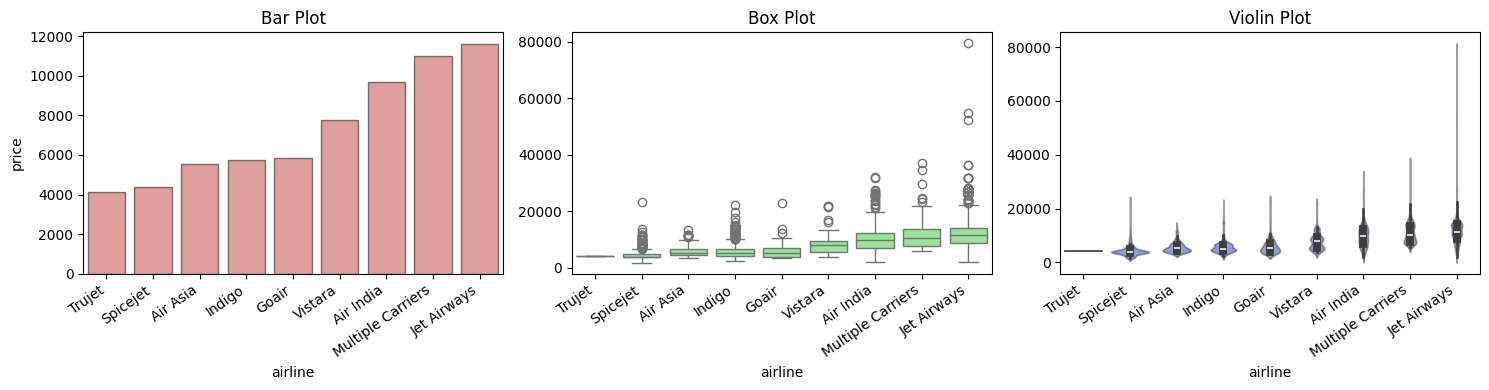

In [28]:
eda_helper_functions.num_cat_bivar_plots(
    data = train,
    num_var="price",
    cat_var = "airline"
)

In [29]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 429.2442358976487
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 2857.276801876773
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


# Multivariate Analysis on Destination, Airline and Price

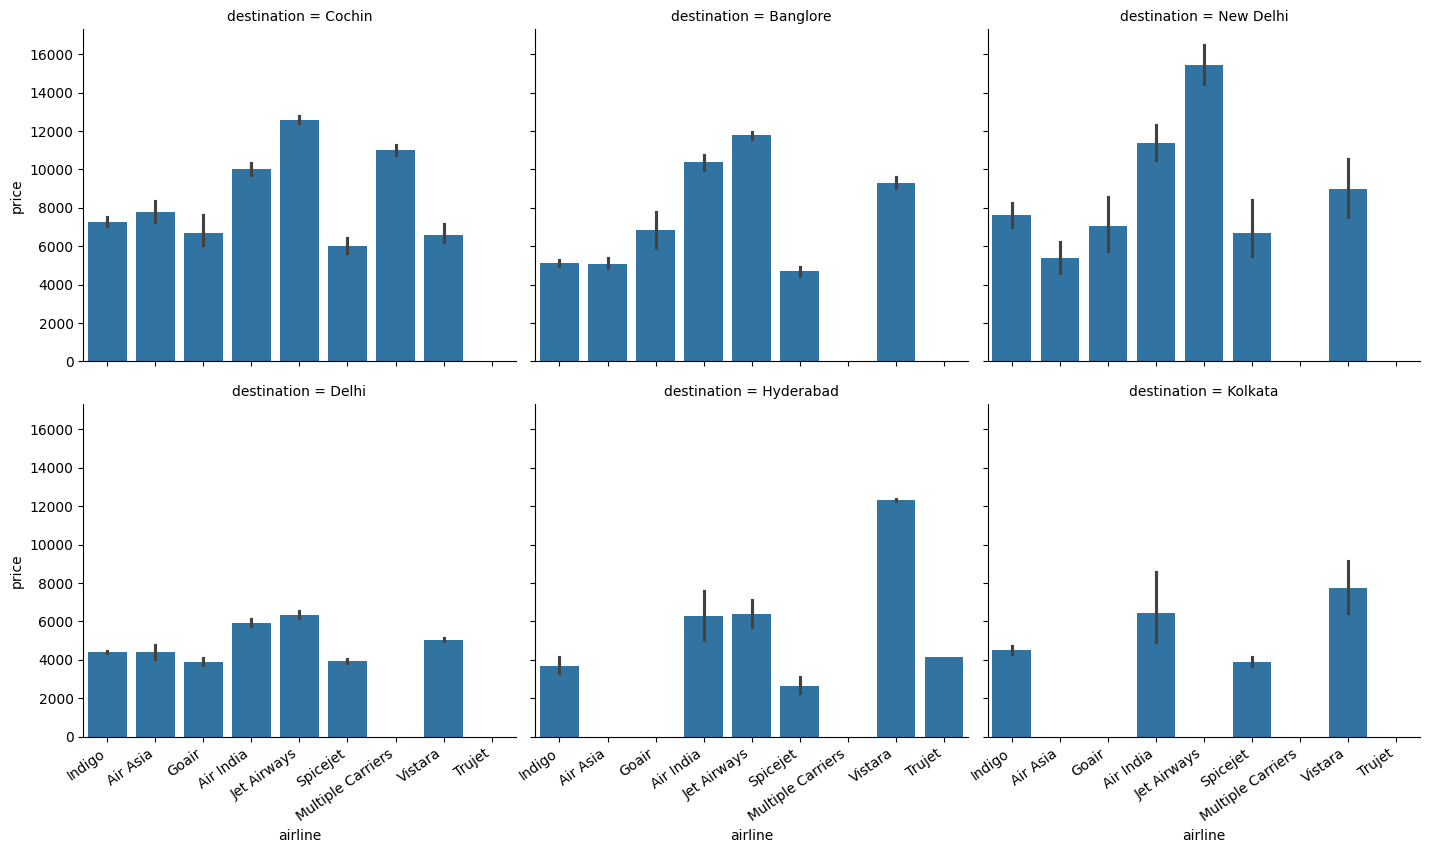

In [30]:
airline_grid = sns.FacetGrid(
    data = train,
    col = "destination",
    col_wrap=3,
    sharey = True,
    height =4,
    aspect = 1.2
    
)

airline_grid.map(sns.barplot, "airline", "price", order = train.airline.unique())

for ax in airline_grid.axes[3:]:
    eda_helper_functions.rotate_labels(ax)


# 8.2 Date_of_journey

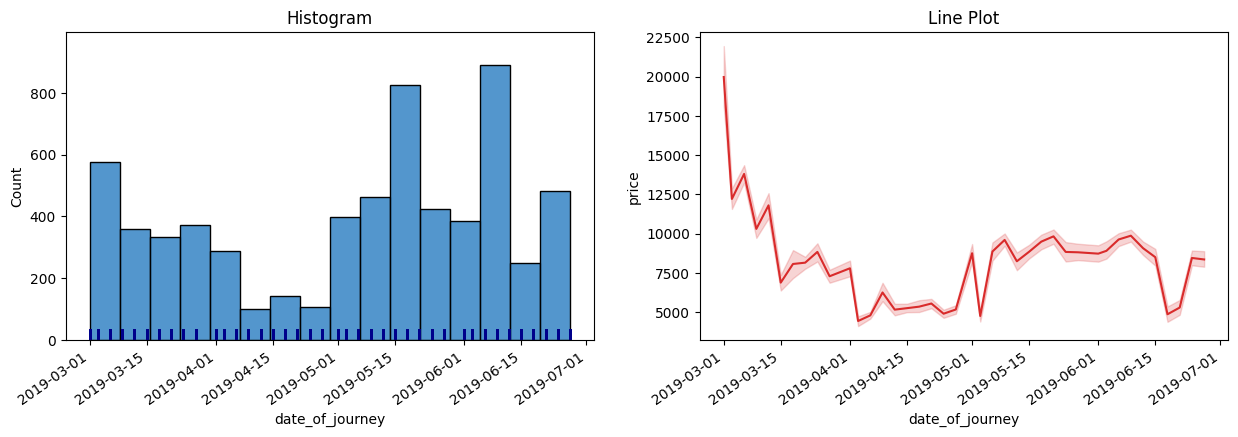

In [31]:
eda_helper_functions.dt_univar_plots(
    data = train,
    var = "date_of_journey",
    target="price"
)

### Per month AVG price

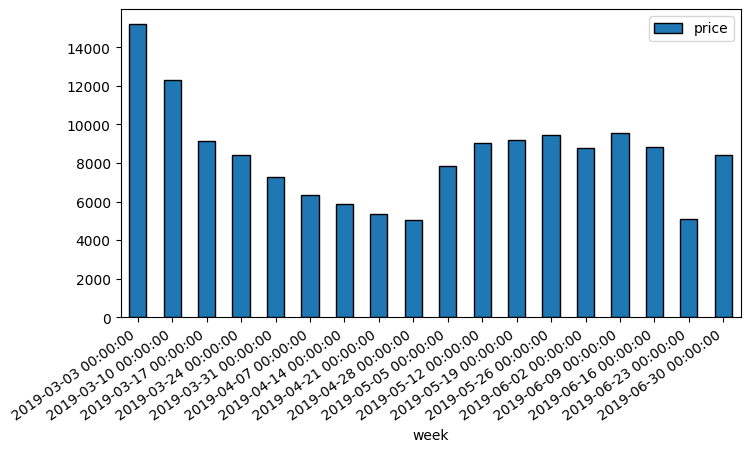

In [32]:
(
    train
    .groupby(pd.Grouper(key ="date_of_journey", freq= "W")) # Convety W to M if need month data
    .price.mean()
    .to_frame()
    # .set_axis(["March","April","May","June"], axis =0)
    .rename_axis(index="week")
    .plot(
        kind = "bar",
        edgecolor = "black",
        figsize = (8,4)
    )
)
ax = plt.gca()
eda_helper_functions.rotate_labels(ax)

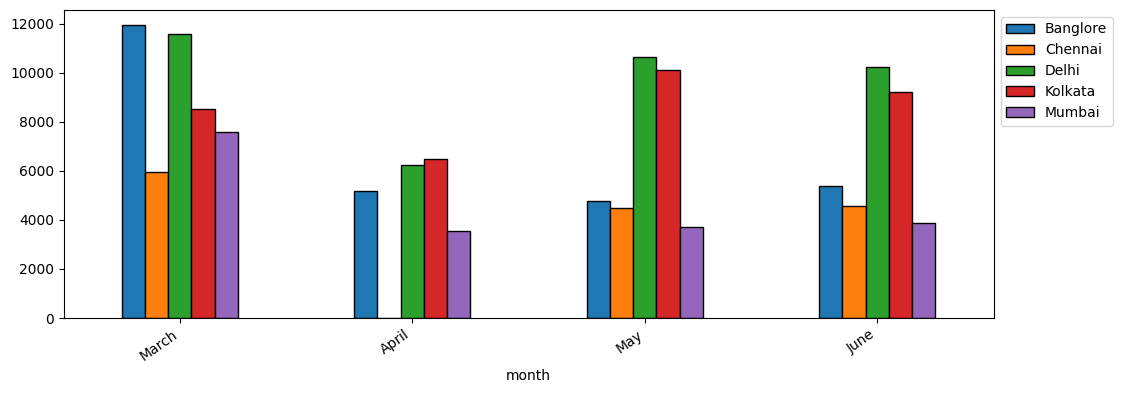

In [33]:
(
    train
    .groupby([pd.Grouper(key="date_of_journey", freq="M"),"source"])
    .price.mean()
    .unstack(fill_value =0)
    .set_axis(["March","April","May","June"], axis =0)
    .rename_axis(index="month")
    .plot(
        kind = "bar",
        edgecolor = "black",
        figsize = (12,4)
    )
)
ax = plt.gca()

ax.legend(
    loc="upper left",
    bbox_to_anchor = (1,1)
)
eda_helper_functions.rotate_labels(ax)

### 8.3 Dep_time 

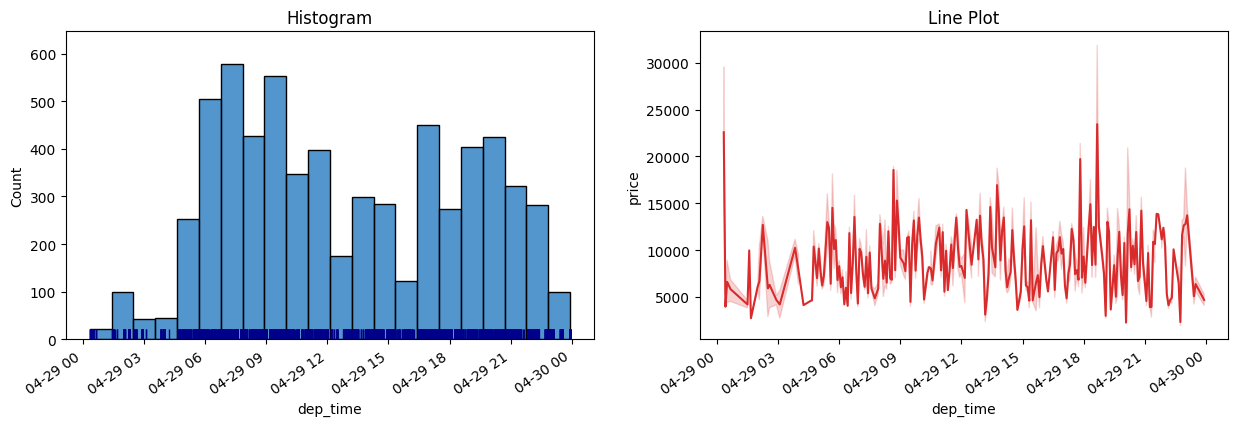

In [34]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

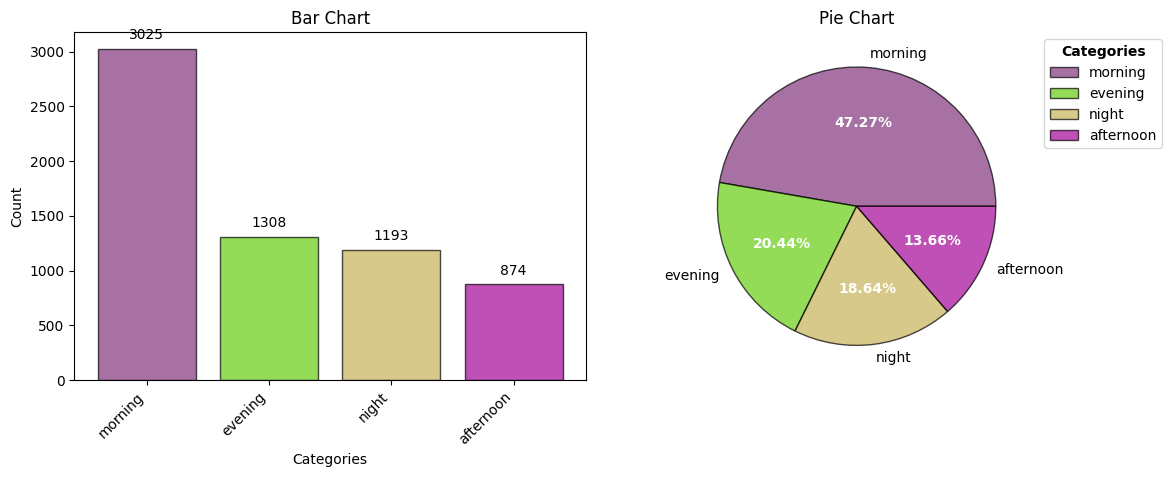

In [35]:
(
    train
    .assign(dep_time = lambda df_: (
        (np.select([df_.dep_time.dt.hour.between(4,12, inclusive = "left"),
                                 df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
                                 df_.dep_time.dt.hour.between(16,20, inclusive = "left")],
                                ["morning", "afternoon", "evening"],
                                default = "night"))
    ))
    .pipe(eda_helper_functions.cat_univar_plots,"dep_time", show_wordcloud = False)    
)

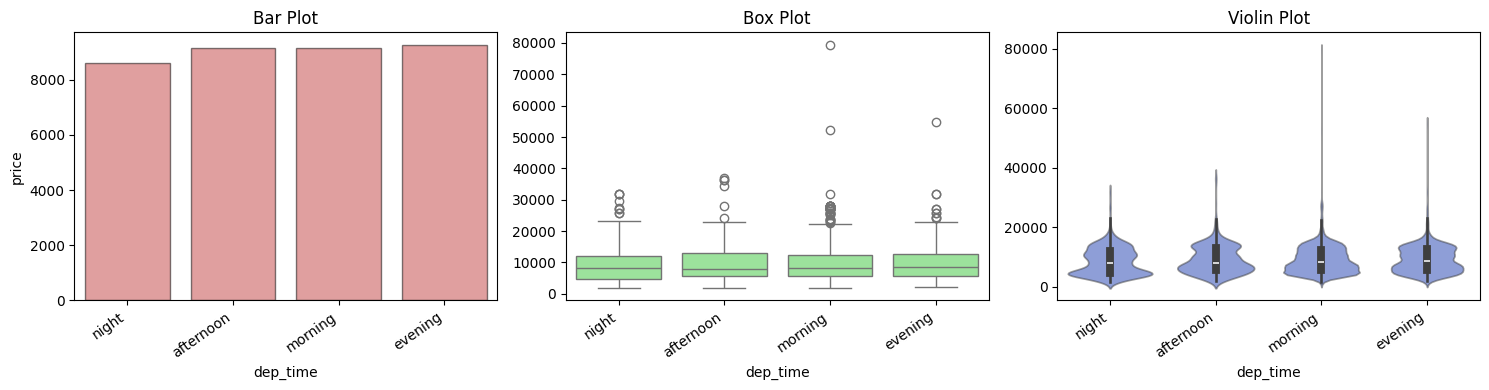

In [36]:
(
    train
    .assign(dep_time = lambda df_: (
        (np.select([df_.dep_time.dt.hour.between(4,12, inclusive = "left"),
                                 df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
                                 df_.dep_time.dt.hour.between(16,20, inclusive = "left")],
                                ["morning", "afternoon", "evening"],
                                default = "night"))
    ))
    .pipe(eda_helper_functions.num_cat_bivar_plots,"price", "dep_time")    
)

### 8.4 Duration

In [37]:
eda_helper_functions.num_summary(train,"duration")

0        305
1        155
2        165
3        495
4        300
        ... 
6395    1220
6396     940
6397     155
6398      90
6399     730
Name: duration, Length: 6400, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,400 / 6,400 rows


,value
percentile,
0,75.0
5,90.0
10,145.0
25,170.0
50,507.5
75,915.0
90,1450.0
95,1615.0
99,1890.1


,value
mean,633.546094
trimmed mean (5%),599.812500
trimmed mean (10%),570.897461
median,507.500000


,value
var,251939.825973
std,501.936078
IQR,745.000000
mad,337.500000
coef_variance,0.792264


,value
skewness,0.897159
kurtosis,-0.079019


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 0.0
Test Statistic       : 0.886758029460907
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 236.74004444522052
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


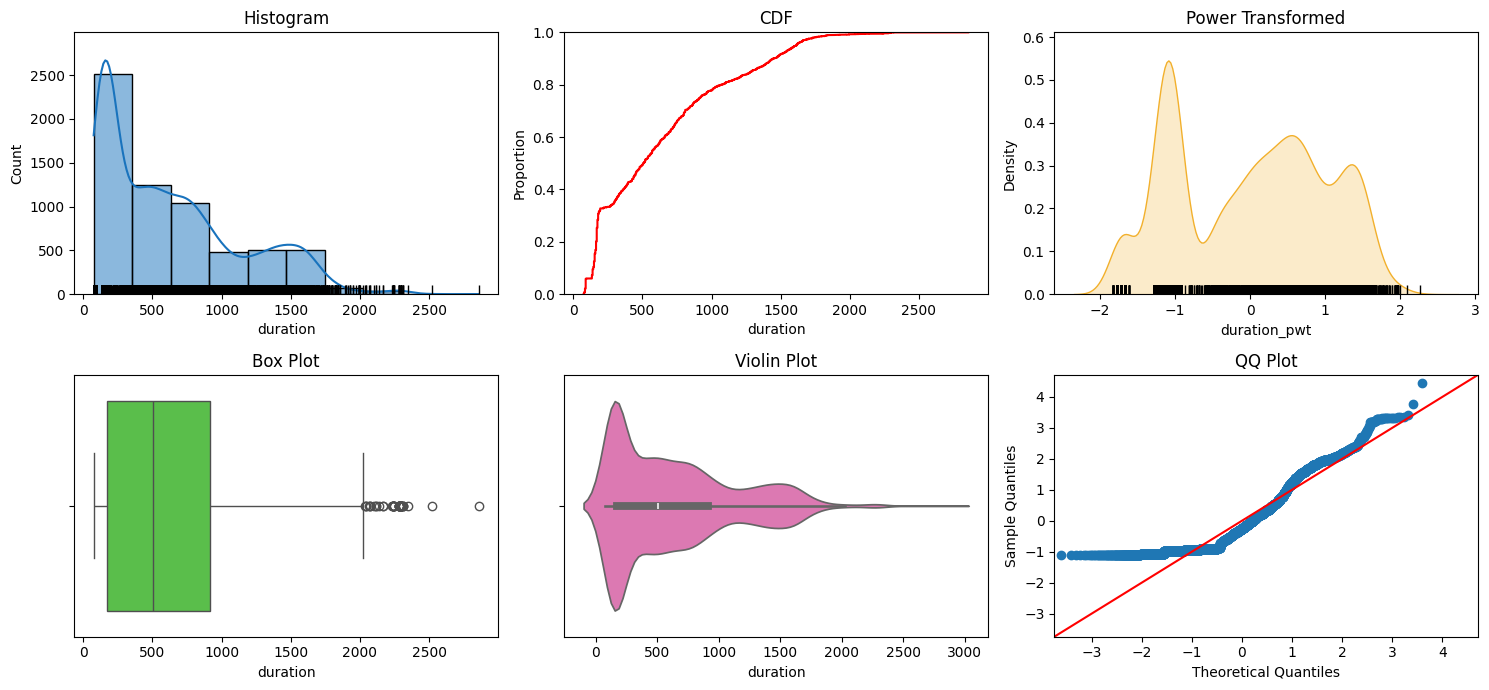

In [38]:
eda_helper_functions.num_univar_plots(train, "duration")

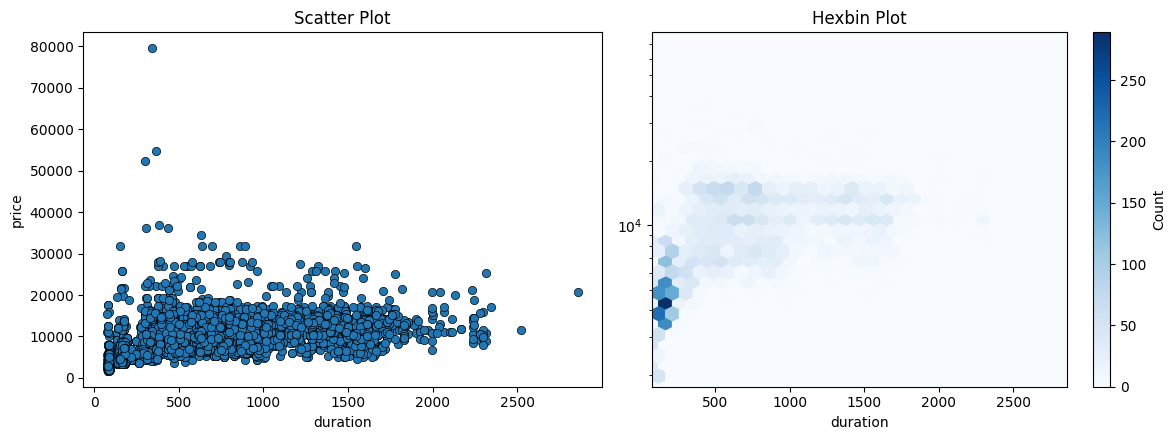

In [46]:
eda_helper_functions.num_bivar_plots(
    train,
    "duration",
    "price",
    hexbin_kwargs=dict(
        yscale="log",
        gridsize=30,
        cmap="Blues"
    )
)

In [47]:
eda_helper_functions.num_num_hyp_testing(train, "price","duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5070541006535623
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6873287811214499
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


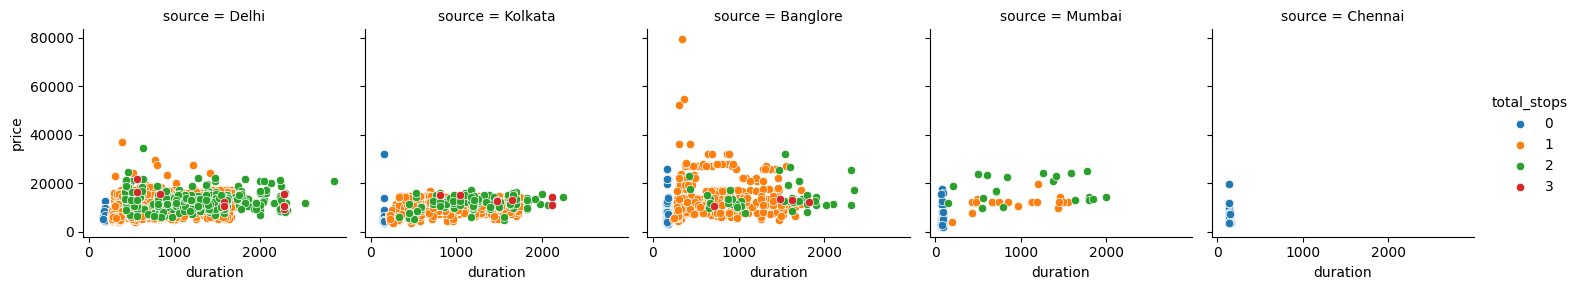

In [55]:
duration_grid = sns.FacetGrid(
    data = train,
    col = "source",
    sharey= True,
    hue="total_stops",
    # row = "additional_info"
)
duration_grid.map(sns.scatterplot, "duration","price")
duration_grid.add_legend()

# Automated EDA

## - Pandas Profiling ( ydata-profiling)
## - Sweetviz
## - AutoViz
## - D-Tale

In [59]:
from ydata_profiling import ProfileReport

In [58]:
# pip install ydata_profiling

In [63]:
report_ydata = ProfileReport(train)

In [64]:
report_ydata.to_file(output_file="output_ydata.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
#pip install dtale

In [82]:
# pip install sweetviz

In [87]:
import sweetviz as sv
report_sweetviz_analyse = sv.analyze(train)

                                             |                                                                …

In [88]:
report_sweetviz_analyse.show_html('sweetviz_report_analyse_train.html')

Report sweetviz_report_analyse_train.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [91]:
file_path_val = r"D:\flight-price-pred-sagemaker\data\validation.csv" 
val =  pd.read_csv(file_path_val)
report_compare = sv.compare(train,val)
report_compare.show_html('sweetviz_report_compare_train_val.html')

                                             |                                                                …

Report sweetviz_report_compare_train_val.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [93]:
# pip install autoviz